**AutoEncoder: Interpolation**

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the related package

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn import model_selection

In [3]:
from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist 

Using TensorFlow backend.


Load the Mnitst data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape each image matrix to a long vector
x_train = np.reshape(x_train, (len(x_train), 28*28))  
x_test = np.reshape(x_test, (len(x_test), 28*28))  
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


**Simple Fully Connected Encoding and Decoding Network**

In [5]:
Input = layers.Input(shape=(28*28,)) # Set up the input for the network

# COnstruct the specific layers of encoding and decoding
x = layers.Dense(256, activation='relu')(Input)
encode = layers.Dense(32, activation='relu')(x) # The original image will be encoded into 32 numerical values
x = layers.Dense(256, activation='relu')(encode)
decode = layers.Dense(28*28, activation='relu')(x)

autoencoder = Model(Input,decode) # Autoencoder model
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               201488    
Total params: 419,120
Trainable params: 419,120
Non-trainable params: 0
_________________________________________________________________


**Seperate the Encoder and Decoder into two models**

Sperately build the encoder and decoder model, so that we could have the encoded vector and use the encoded vector to do decoding manually.

It's very important to match the input and output shape when dealing with the model seperately. After the training process of the autoencoder network, the encoder and decoder model would also be trained.

In [6]:
FC = Model(Input, encode) # The encoder network

# create a placeholder for an encoded (32-dimensional) input
encoded_input = layers.Input(shape=(32,))
d = autoencoder.layers[3](encoded_input)
d = autoencoder.layers[4](d)

# create the decoder model
decoder = Model(encoded_input, d)

print(FC.summary())
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
Total params: 209,184
Trainable params: 209,184
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8448      
_________________________________________________________________

**Train the Autoencoder model**

In [7]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error') 
autoencoder.fit(x_train, x_train,epochs=5,batch_size=256)
autoencoder.evaluate(x_test,x_test)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.0310
Epoch 2/5
60000/60000 [==============================] - 4s 73us/step - loss: 0.0161
Epoch 3/5
60000/60000 [==============================] - 4s 74us/step - loss: 0.0147
Epoch 4/5
60000/60000 [==============================] - 4s 73us/step - loss: 0.0139
Epoch 5/5
10000/10000 [==============================] - 1s 52us/step


0.013037955099344254

**Check our models' Performance**

To make sure that our seperated encoder and decoder model seccessfully stored the trainned parameters, we would do the prediction on test dataset and compare the result from the Autoencoder model and the decoder model.

In [0]:
# The Function used to plot the original image and the predicted image
def Plot_Img(n,k,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k, k))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

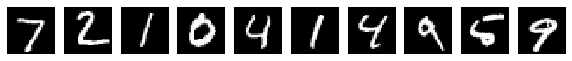

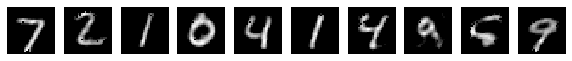

In [31]:
decoded_imgs = autoencoder.predict(x_test) # The autoencoder model Reconstructed Images
Plot_Img(10,28,x_test,10,4) # Plot the original test images
Plot_Img(10,28,decoded_imgs,10,4) # Plot the Reconstructed images

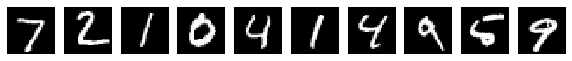

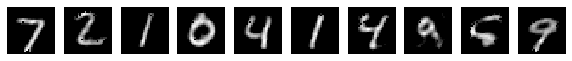

In [32]:
FC_value = FC.predict(x_test) # Encoded Values of the test images
decoded_imgs = decoder.predict(FC_value) # Reconstructed images based on the encoded values
Plot_Img(10,28,x_test,10,4) # Plot the original test images
Plot_Img(10,28,decoded_imgs,10,4) # Plot the Reconstructed images

**Interpolation**

Now we are going to do the Interpolation for the Mnist data. The interpolation would give us a chance to see the path of one image becoming another. The idea behind the interpolation is that by comparing the encoded values of two images and then chance the encoded value of one image slowly to the encoded value of the other image and reconstruct the images based on all these encoded values. If our model is good enough, we could clearly see how one image slowly becomes another one.

For our case, I just use the first and the second image of the test set ('7' and '2') as the images for the interpolation process. The stages of 7 becoming to 2 are supposed to display by chosen number of steps.

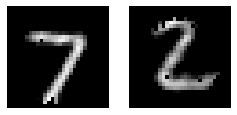

In [33]:
FC_value1 = FC.predict(x_test[0:1]) # The encoded value of '7'
decoded_img1 = decoder.predict(FC_value1) # The reconstructed image of '7'
FC_value2 = FC.predict(x_test[1:2]) # The encoded value of '2'
decoded_img2 = decoder.predict(FC_value2) # The reconstructed image of '2'
chosen_images = [decoded_img1,decoded_img2]

# Plot '7' and '2'
Plot_Img(2,28,chosen_images,4,2)

In [34]:
# Print the Encoded values of '7' and '2'
print(FC_value1)
print(FC_value2)

[[2.2719595  2.4785306  2.220612   1.7945021  1.7087233  3.5676308
  2.2763834  2.4103832  5.9682317  1.4805405  3.2464151  0.7810777
  2.979178   3.4388142  1.0605386  0.75198185 2.7688842  0.
  3.195774   2.7866964  3.9683962  3.900435   1.0533118  1.4853323
  2.3455448  1.8628466  2.7977872  0.9904892  1.1289184  1.357431
  3.2576802  1.7926122 ]]
[[2.960186  3.1163313 1.7365583 3.3820727 3.7084548 1.8893528 3.5948102
  1.752847  4.638738  2.5077817 2.7789745 4.213141  1.6488767 3.957506
  6.2492805 1.8928248 2.387298  0.        2.6579082 2.6025467 3.5310364
  1.8722122 1.661354  3.5438454 3.343161  2.3461673 1.1270391 5.1498766
  0.6402574 3.9461849 0.8611719 1.9097433]]


The interpolation function

In [0]:
# The Interpolation Function
def Interpolation(n_step,intp_images,encoder,decoder):
  
    # n_step is how many steps we want to see during the interpolation process
    FC_start = encoder.predict(intp_images[0])
    FC_end = encoder.predict(intp_images[1])
    step = (FC_end-FC_start)/n_step
    FC_intps = [FC_start+t*step for t in range(n_step+1)]
    decode_imgs_intp = [decoder.predict(FC_i) for FC_i in FC_intps]
    
    return decode_imgs_intp

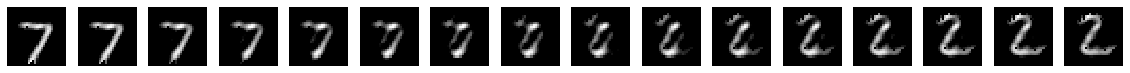

In [41]:
decode_imgs_intp = Interpolation(15,[x_test[0:1],x_test[1:2]],FC,decoder)
Plot_Img(len(decode_imgs_intp),28,decode_imgs_intp,20,4)

Let's try some other examples

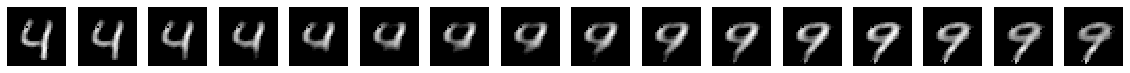

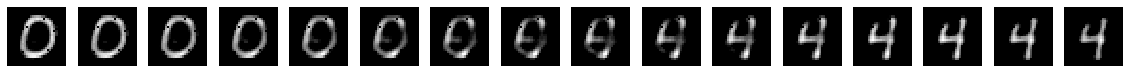

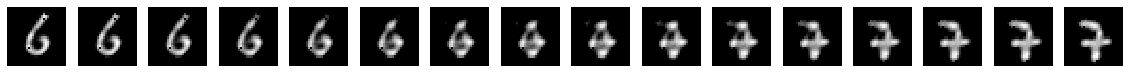

In [51]:
decode_imgs_intp = Interpolation(15,[x_test[4:5],x_test[9:10]],FC,decoder)
Plot_Img(len(decode_imgs_intp),28,decode_imgs_intp,20,4)
decode_imgs_intp = Interpolation(15,[x_test[10:11],x_test[19:20]],FC,decoder)
Plot_Img(len(decode_imgs_intp),28,decode_imgs_intp,20,4)
decode_imgs_intp = Interpolation(15,[x_test[50:51],x_test[301:302]],FC,decoder)
Plot_Img(len(decode_imgs_intp),28,decode_imgs_intp,20,4)

**Save the Autoencoder models**

In [0]:
from keras.models import load_model

autoencoder.save('/content/drive/My Drive/Colab Notebooks/Thesis/Models/autoencoder.h5')
FC.save('/content/drive/My Drive/Colab Notebooks/Thesis/Models/FC.h5')
decoder.save('/content/drive/My Drive/Colab Notebooks/Thesis/Models/decoder.h5')

#autoencoder = load_model('/content/drive/My Drive/Colab Notebooks/Thesis/autoencoder.h5')

**Interpolation to the Human Face Images: From Female to Male/From Male to Female**

Let's try to construct ConvNet Autoencoder on the human face imges and do the Interpolation on male and femal images.

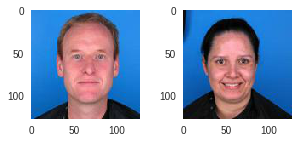

In [57]:
pwd = '/content/drive/My Drive/Colab Notebooks/Thesis/data/utrecht/*.jpg'
base = '/content/drive/My Drive/Colab Notebooks/Thesis/data/utrecht/'

# Read the image from the google drive and display two examples.
img = glob.glob(pwd)

fig = plt.figure(figsize = (5,2))
ax = fig.add_subplot(1,2,1)
ax.grid(False)
plt.imshow(mpimg.imread(img[0]))
ax = fig.add_subplot(1,2,2)
ax.grid(False)
plt.imshow(mpimg.imread(img[10]))

In [0]:
img_names = model_selection.train_test_split(img) # Split the test and train set

# Read all the images
im_train = np.array([mpimg.imread(a) for a in img_names[0]])
im_test = np.array([mpimg.imread(a) for a in img_names[1]])

# Standardize the images
im_train = im_train.astype('float32') / 255.
im_test = im_test.astype('float32') / 255.

**The Convnet-Deconvnet Autoencoder for all three channels**

In [58]:
Input = layers.Input(shape=(128,128,3))

x = layers.Conv2D(8,(3,3),activation='relu',padding='same')(Input)
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.Conv2D(32,(3,3),activation='relu',padding='same')(x)
encode = layers.Dense(32,activation='relu')(x)

x = layers.Conv2DTranspose(32,(4,4),activation='relu',padding='same')(encode)
x = layers.Conv2DTranspose(16,(4,4),activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(8,(4,4),activation='relu',padding='same')(x)
decode = layers.Conv2DTranspose(3,(4,4),activation='sigmoid',padding='same')(x)

Autoencoder = Model(Input,decode)
Autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
dense_5 (Dense)              (None, 128, 128, 32)      1056      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 32)      16416     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 16)      8208      
__________

**Seperate the Encoder and Decoder model**

In [60]:
encoder = Model(Input,encode)
encode_input = layers.Input(shape=(128,128,32))
d = Autoencoder.layers[5](encode_input)
d = Autoencoder.layers[6](d)
d = Autoencoder.layers[7](d)
d = Autoencoder.layers[8](d)
decoder = Model(encode_input,d)

print(encoder.summary())
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
dense_5 (Dense)              (None, 128, 128, 32)      1056      
Total params: 7,088
Trainable params: 7,088
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp

**Train the autoencoder model**

In [61]:
Autoencoder.compile(optimizer='adam', loss='mean_squared_error')
Autoencoder.fit(im_train, im_train, epochs=30,batch_size=10)
Autoencoder.evaluate(im_test,im_test)

Epoch 1/30
91/91 [==============================] - 17s 188ms/step - loss: 0.0798
Epoch 2/30
91/91 [==============================] - 16s 175ms/step - loss: 0.0440
Epoch 3/30
91/91 [==============================] - 16s 180ms/step - loss: 0.0164
Epoch 4/30
91/91 [==============================] - 16s 181ms/step - loss: 0.0092
Epoch 5/30
91/91 [==============================] - 16s 180ms/step - loss: 0.0077
Epoch 6/30
91/91 [==============================] - 16s 179ms/step - loss: 0.0064
Epoch 7/30
91/91 [==============================] - 16s 179ms/step - loss: 0.0050
Epoch 8/30
91/91 [==============================] - 16s 179ms/step - loss: 0.0045
Epoch 9/30
91/91 [==============================] - 16s 178ms/step - loss: 0.0038
Epoch 10/30
91/91 [==============================] - 16s 181ms/step - loss: 0.0036
Epoch 11/30
91/91 [==============================] - 17s 189ms/step - loss: 0.0035
Epoch 12/30
91/91 [==============================] - 17s 187ms/step - loss: 0.0029
Epoch 13/30
9

0.00139076285995543

**Functions used to do plotting and the interpolation process**

In [0]:
# The Function used to plot the original image and the predicted image
def Plot_Img(n,k,images,fig_w,fig_h):
    # n is how many digits we will display
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k, k, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
# The Interpolation Function
def Interpolation(n_step,intp_images,encoder,decoder):
  
    # n_step is how many steps we want to see during the interpolation process
    FC_start = encoder.predict(intp_images[0])
    FC_start = FC_start.reshape((FC_start.shape[0],np.prod(FC_start.shape[1:])))
    FC_end = encoder.predict(intp_images[1])
    FC_end = FC_end.reshape((FC_end.shape[0],np.prod(FC_end.shape[1:])))
    step = (FC_end-FC_start)/n_step
    FC_intps = [(FC_start+t*step).reshape((1,128,128,32)) for t in range(n_step+1)]
    decode_imgs_intp = [decoder.predict(FC_i) for FC_i in FC_intps]
    
    return decode_imgs_intp

**Show the reconstructed images**

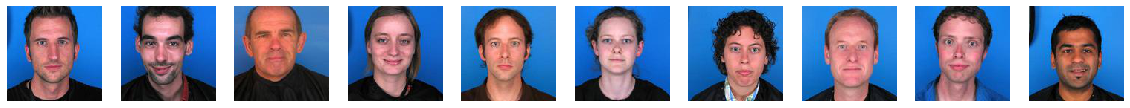

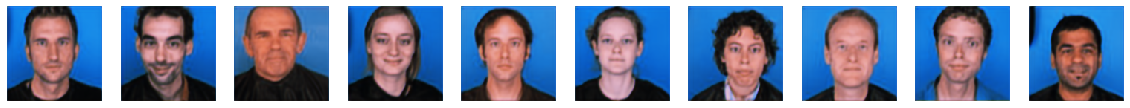

In [66]:
FC_pred = encoder.predict(im_test)
decoded_imgs = decoder.predict(FC_pred)
Plot_Img(10,128,im_test,20,4)
Plot_Img(10,128,decoded_imgs,20,4)

**The Interpolation between a male image and a male image**

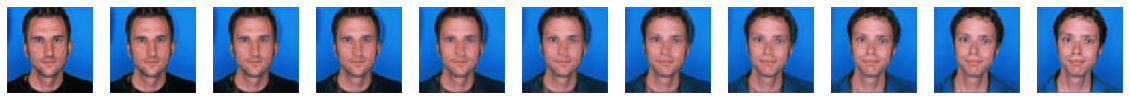

In [84]:
decode_imgs_intps = Interpolation(10,[im_test[0:1],im_test[8:9]],encoder,decoder)
Plot_Img(len(decode_imgs_intps),128,decode_imgs_intps,20,4)

**The interpolation between a female image and a female image**

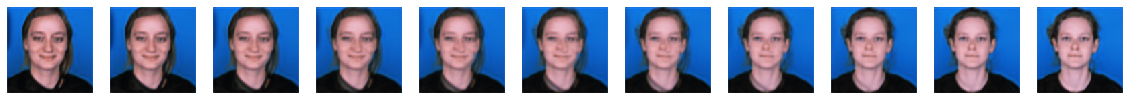

In [85]:
decode_imgs_intps = Interpolation(10,[im_test[3:4],im_test[5:6]],encoder,decoder)
Plot_Img(len(decode_imgs_intps),128,decode_imgs_intps,20,4)

**The interpolation between a male image and a female image**

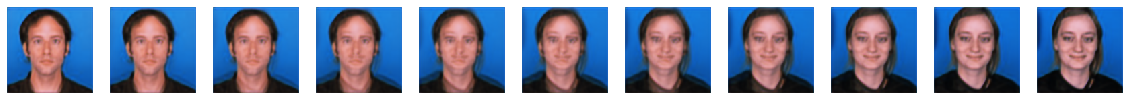

In [86]:
decode_imgs_intps = Interpolation(10,[im_test[4:5],im_test[3:4]],encoder,decoder)
Plot_Img(len(decode_imgs_intps),128,decode_imgs_intps,20,4)

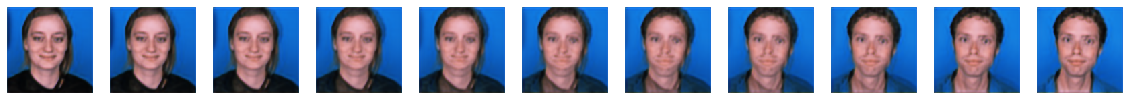

In [87]:
decode_imgs_intps = Interpolation(10,[im_test[3:4],im_test[8:9]],encoder,decoder)
Plot_Img(len(decode_imgs_intps),128,decode_imgs_intps,20,4)